This notebook illustrates phase retrieval with a shrinkwrap algorithm. 

Date Created: 5 Mar 2018
<br>
Last Modified: 7 Mar 2018 
<br>
Humans Responsible: The Prickly Pythons

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

In [5]:
from scipy.misc import imread
from skimage import color
from skimage import transform

Nx = 64
Ny = 64

x_true = imread("cat.png")
x_true = color.rgb2gray(x_true)
x_true = transform.resize(x_true, (Nx, Ny))
x_true = x_true/np.max(x_true)
x_true[x_true < 1e-1] = 0 

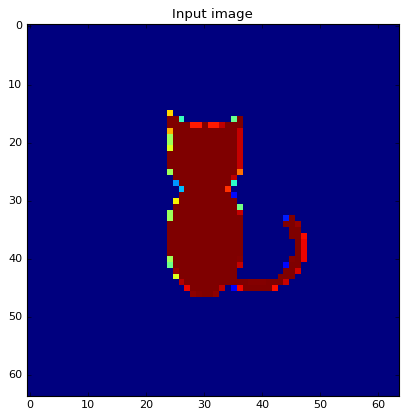

In [6]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
im = ax.imshow(x_true, interpolation='nearest')
ax.set_title('Input image')

plt.show()

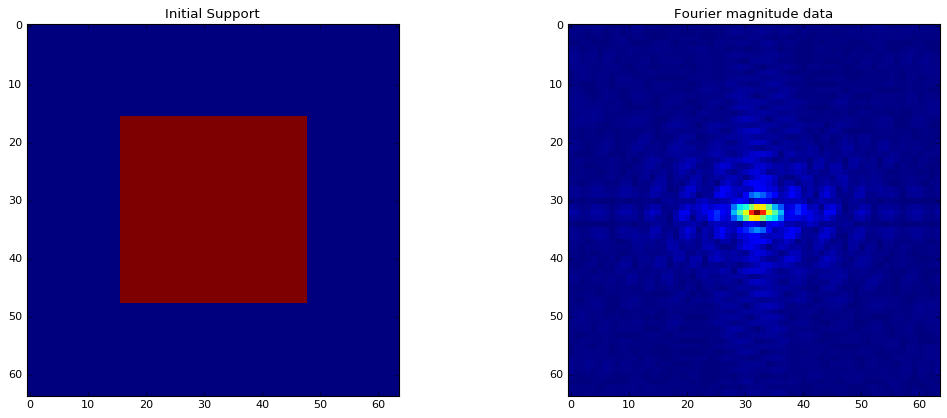

In [7]:
# Now take the Fourier transform of the cat
X_true = np.fft.fftn(x_true)
M_true = np.abs(X_true)

# Make initial support
supp = np.zeros([Nx,Ny])
supp[16:48,16:48] = 1

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
im = ax.imshow(supp, interpolation='nearest')
ax.set_title('Initial Support')
ax = fig.add_subplot(122)
im = ax.imshow(np.fft.fftshift(M_true), interpolation='nearest')
ax.set_title('Fourier magnitude data')

plt.show()

In [8]:
# Define the projectors
def P_S(x, S_in):
    x_new = x*S_in['supp']
    return x_new

def P_M(x, M_in):
    X = np.fft.fftn(x)
    X_new = X/(np.abs(X)) * M_in['M_data']
    x_new = np.fft.ifftn(X_new)
    return x_new

In [9]:
def R_M(x, gamma_M, M_in):
    return (1+gamma_M)*P_M(x, M_in) - gamma_M*x

def R_S(x, gamma_S, S_in):
    return (1+gamma_S)*P_S(x, S_in) - gamma_S*x

In [10]:
C = np.zeros([Nx,Ny])
C = np.fft.fftshift(C)
C[20:44,20:44] = 1 # Magic numbers
C = np.fft.ifftshift(C)

def low_pass_filter(x):
    X = np.fft.fftn(x)
    X_new = X * C
    x_new = np.abs(np.fft.ifftn(X_new))
    return x_new

<IPython.core.display.Javascript object>


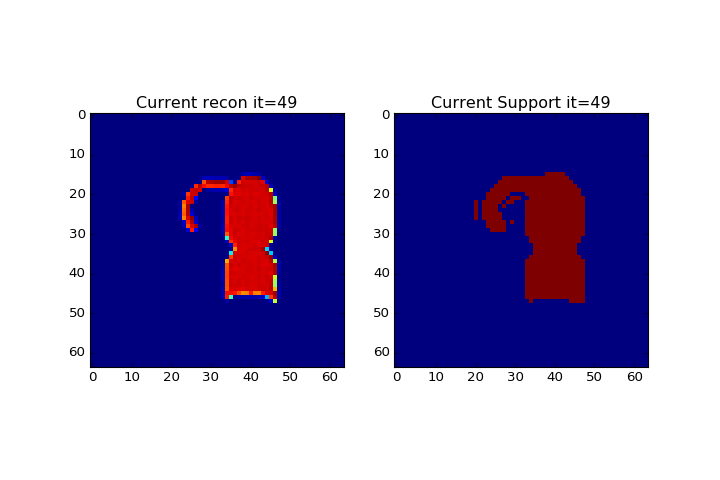

In [12]:
%matplotlib notebook

# Input data to the algorithm
S_in = {'supp':supp}
M_in = {'M_data':M_true}

it_max = 50

beta = 0.8 # Magic number
gamma_M = -1/beta
gamma_S = 1/beta

x = np.random.rand(Nx,Ny)

supp_new = supp

fig = plt.figure(figsize=(9,6))

for it in range(it_max):
    
    # Update rule - so-called the "Difference Map"
    x_PM = P_M(R_S(x, gamma_S, S_in), M_in)
    x_PS = P_S(R_M(x, gamma_M, M_in), S_in)
    x_new = x + beta*(x_PM - x_PS)
    
    x = x_new
    
    x_sol = x_PS
    
    # Shrinkwrap
    if np.mod(it,10) == 9: # Magic number
        x_mod = low_pass_filter(x_sol)
        supp_new = x_mod/np.max(x_mod) > 0.12 # Magic number
        S_in = {'supp':supp_new}
    
    # Visualize
    ax = fig.add_subplot(121)
    im = ax.imshow(np.abs(x_sol), interpolation='nearest')
    ax.set_title("Current recon it=%d" % it)
    ax = fig.add_subplot(122)
    im = ax.imshow(supp_new, interpolation='nearest')
    ax.set_title("Current Support it=%d" % it)
    fig.canvas.draw()
    time.sleep(0.1)

%matplotlib inline

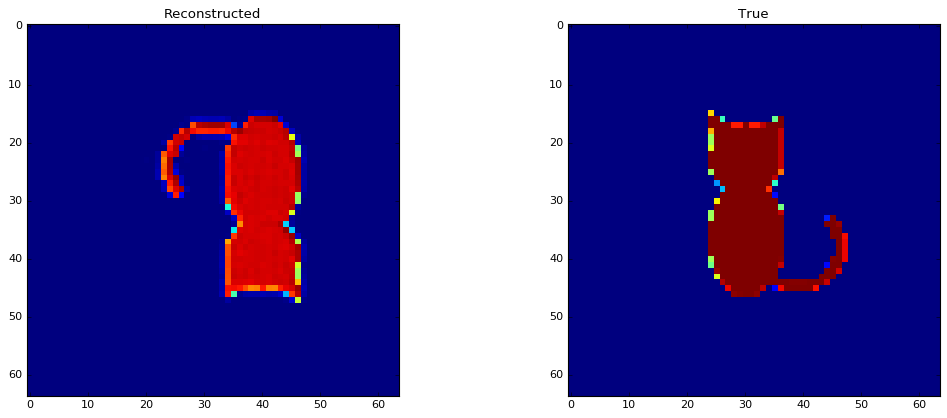

In [13]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
im = ax.imshow(np.abs(x_sol), interpolation='nearest')
ax.set_title('Reconstructed')
ax = fig.add_subplot(122)
im = ax.imshow(x_true, interpolation='nearest')
ax.set_title('True')

plt.show()

In [14]:
# Question to you: Why is the cat upside down?